## Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Download speech data

In [1]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Nothing to do.
Nothing to do.


In [2]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test']) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835


In [3]:
trainDF.head()

,files,labels,category
0,speechData/train/no/1ecfb537_nohash_3.wav,9,no
1,speechData/train/dog/d0ce2418_nohash_0.wav,8,dog
2,speechData/train/up/37a3cd33_nohash_0.wav,24,up
3,speechData/train/left/36050ef3_nohash_4.wav,13,left
4,speechData/train/seven/b8897f1c_nohash_0.wav,11,seven


## Tensorflow 2.0

In [6]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 66kB/s 
     |████████████████████████████████| 3.1MB 51.7MB/s 
     |████████████████████████████████| 501kB 57.9MB/s 


In [4]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


## Input pipeline

In [0]:
!pip install -q python_speech_features

In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 30000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False
)

test_data, test_steps = getDataset(
    df=testDF,
    batch_size=BATCH_SIZE,
    cache_file='test_cache',
    shuffle=False
) 


## Model

In [7]:
from models import cnnModel

model = cnnModel()

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 99, 40, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 40, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 40, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 40, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 99, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 40, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 99, 40, 16)        6

In [11]:
EPOCHS = 25

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR])



W0628 09:28:45.066293 139958829594368 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0628 09:28:45.068855 139958821201664 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0628 09:28:45.070108 139958829594368 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0628 09:28:45.073784 139958821201664 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0628 09:28:45.087097 139958829594368 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


Epoch 1/25


W0628 09:30:43.508150 139962044290944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


937/937 [==============================] - 182s 194ms/step - loss: 1.2450 - sparse_categorical_accuracy: 0.6333 - val_loss: 0.4257 - val_sparse_categorical_accuracy: 0.8710
Epoch 2/25
937/937 [==============================] - 25s 26ms/step - loss: 0.4056 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.3490 - val_sparse_categorical_accuracy: 0.8990
Epoch 3/25
937/937 [==============================] - 23s 25ms/step - loss: 0.3098 - sparse_categorical_accuracy: 0.9076 - val_loss: 0.3461 - val_sparse_categorical_accuracy: 0.8937
Epoch 4/25
937/937 [==============================] - 23s 25ms/step - loss: 0.2549 - sparse_categorical_accuracy: 0.9219 - val_loss: 0.3392 - val_sparse_categorical_accuracy: 0.9070
Epoch 5/25
937/937 [==============================] - 23s 25ms/step - loss: 0.2194 - sparse_categorical_accuracy: 0.9336 - val_loss: 0.2959 - val_sparse_categorical_accuracy: 0.9145
Epoch 6/25
937/937 [==============================] - 23s 25ms/step - loss: 0.1996 - sparse_categor

## Save model and trainign history  to drive

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir /content/gdrive/My\ Drive/speechRecognition/cnnModel

In [17]:
GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/cnnModel/"

## Save model 
model_json = model.to_json()
with open(GDRIVE_PATH + "model.json", "w") as file:
    file.write(model_json)
# serialize weights to HDF5
model.save_weights(GDRIVE_PATH + "model_weights.h5")
print("Saved model to drive")

Saved model to drive


In [19]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_results.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


In [0]:
## test load
with open(GDRIVE_PATH + "train_results.pickle", 'rb') as handle:
    hist = pickle.load(handle)

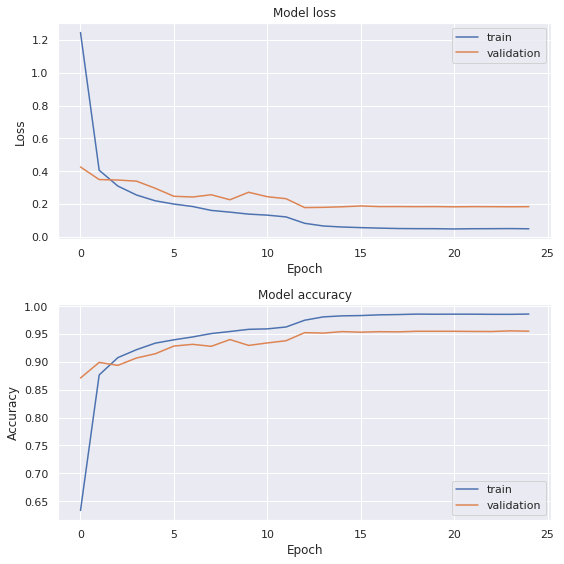

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

acc = hist['sparse_categorical_accuracy']
val_acc = hist['val_sparse_categorical_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

### Predict



In [22]:
out = model.predict(test_data, verbose=1)

214/214 [==============================] - 34s 160ms/step


In [0]:
import numpy as np
y_pred = np.argmax(out,axis=1)
y_true = testDF['labels'].tolist()

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('Accuracy: {:.4f}'.format(accuracy_score(y_pred, y_true)))
cm = confusion_matrix(y_pred, y_true)

Accuracy: 0.9593


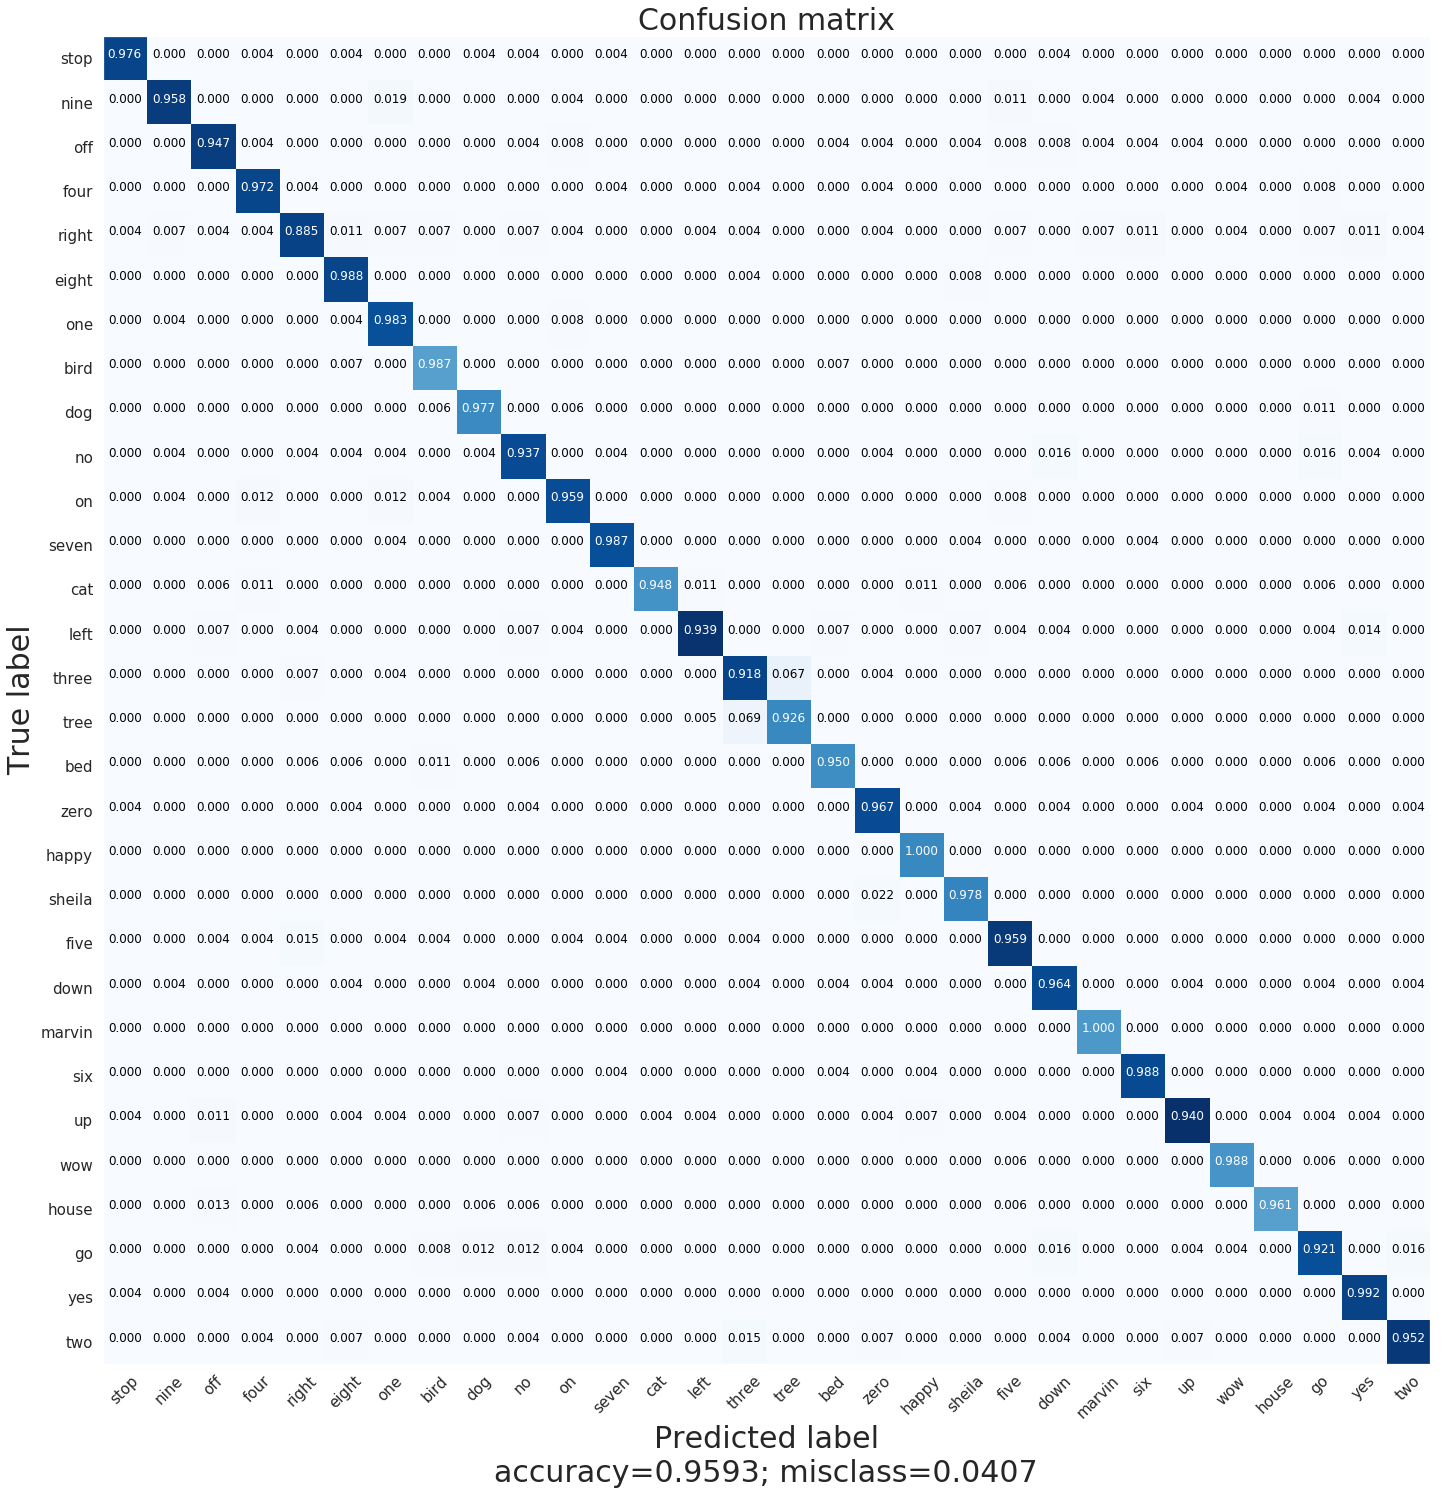

In [38]:
from analysisFuntions import plot_confusion_matrix
    
plot_confusion_matrix(cm, target_names=list(inv_categories.values())[:-1], normalize=True)